# Predicting HI profiles 

This notebook was derived from hi-observe.py, which is the command line version of extracting spectra from a FITS cube. The output figure can be compared to the strip chart you have obtained with the 40ft.


In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord


First two convenience functions that transform between RA,DEC and GLON,GLAT

In [2]:
def radec_glonlat(rah,ram,ras,dec):
    """
    Simple conversion of 40ft RA(LST)/DEC to GLON/GLAT
    E.g. is LST = 12:10:30 and DEC=52 you would call
    this routine as   (glon,glat) = radec_glonlat(12,10,30,52)
    """
    r = rah*u.hour  + ram*u.minute + ras*u.second
    d = dec*u.deg
    c = SkyCoord(ra=r, dec=d, frame='icrs')
    g = c.galactic.to_string().split()
    return (float(g[0]),float(g[1]))


In [3]:
def glonlat_radec(glon,glat):
    """
    Convert GLON/GLAT to RA/DEC
    """
    lon = glon*u.deg
    lat = glat*u.deg
    c = SkyCoord(l=lon, b=lat, frame='galactic')
    g = c.icrs.to_string().split()
    return (float(g[0]),float(g[1]))


It is always good to have a quick (regression) test to see if the function still works as when we wrote it.


In [4]:
if True:
    # testing the functions
    (glon,glat) = radec_glonlat(21,0,0,42)
    (ra,dec)    = glonlat_radec(glon,glat)
    print("test1: radec_glonlat(20,58,15,42) should produce 83.886 -2.67928:   %g %g" % (glon,glat))
    print("test2: glonlat_radec(glon,glat)   should produce 315 42:            %g %g" % (ra,dec))


test1: radec_glonlat(20,58,15,42) should produce 83.886 -2.67928:   83.886 -2.67928
test2: glonlat_radec(glon,glat)   should produce 315 42:            315 42


some constants we might need (but actually not in the current code)

In [5]:
c        = 299792.458         # speed of light in km/s
restfreq = 1420.405751786     # HI restfreq in MHz



Now we set the input parameters for the spectrum. The filename, and the position, but we allow 3 methods to enter the position.

In [6]:
fitsfile = 'BL.fits'

method = 2

if method == 1:                                           # give the GLON/GLAT
    xpos = 83.0
    ypos = -2.0
    have_pixel = False
elif method == 2:                                         # give the RA/DEC   
    rah = 20
    ram = 58
    ras = 15
    dec = 42
    (xpos,ypos)= radec_glonlat(rah,ram,ras,dec)
    have_pixel = False
else:                                                      # give the pixel coordinates
    xpos = 612
    ypos = 193
    have_pixel = True
    

In [7]:
# open the fits file (a FITS file has one or more Header-Data-Unit's, HDU's)
hdu = fits.open(fitsfile)

# get a reference to the primary header and data.
h = hdu[0].header
d = hdu[0].data.squeeze()
print("Shape of cube: :",d.shape)
if len(d.shape) != 3:                 # The data better be 3-dim numpy array now
    print("Your cube is not 3D")
    sys.exit(1)

# get the important coordinate conversion factors that scale between pixels and WCS

# axis 1 is GLON, in degrees
cdelt1 = h['CDELT1']
crval1 = h['CRVAL1']
crpix1 = h['CRPIX1']

# axis 2 is GLAT, in degrees
cdelt2 = h['CDELT2']
crval2 = h['CRVAL2']
crpix2 = h['CRPIX2']

# axis 3 is FELO, velocities in m/s (which we convert to km/s)
cdelt3 = h['CDELT3']
crval3 = h['CRVAL3']
crpix3 = h['CRPIX3']


Shape of cube: : (145, 400, 800)


In [8]:
if not have_pixel:
    # need to convert the xpos,ypos (in WCS) to pixel
    #    xpos_wcs = (xpos_pix - crpix + 1) * cdelt + crval
    #    xpos_pix = (xpos_wcs - crval)/cdelt + crpix - 1
    xposl = xpos
    yposb = ypos
    xpos = (xposl - crval1)/cdelt1 + crpix1 - 1 
    ypos = (yposb - crval2)/cdelt2 + crpix2 - 1
    print("Pixel: %g %g (converted from WCS %g %g)" % (xpos,ypos,xposl,yposb))
    xpos = int(xpos)
    ypos = int(ypos)

Pixel: 613.292 194.106 (converted from WCS 83.673 -2.43343)


Now we grab get the spectrum using a numpy slice operation.
This will be the Y (intensity) coordinate in the plot.


In [9]:
flux     = d[:,ypos,xpos]

#   some helper arrays for the X (velocity) coordinate in the plot
nchan    = d.shape[0]       
zero     = np.zeros(nchan)
channeln = np.arange(nchan)
channelf = (channeln-crpix3+1)*cdelt3 + crval3   # WCS in m/s, notice channeln starts at 0
channelv = channelf / 1000.0                     # convert assumed m/s to km/s
print("MinMax in velocities:",channelv.min(), channelv.max())



MinMax in velocities: -360.0 360.0


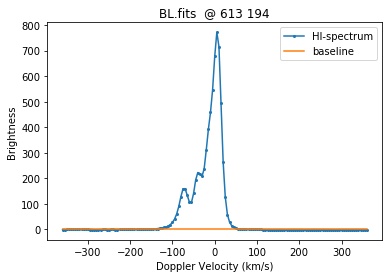

In [10]:
plt.plot(channelv,flux,'o-',markersize=2,label='HI-spectrum')
plt.plot(channelv,zero,                  label='baseline')
plt.xlabel("Doppler Velocity (km/s)")
plt.ylabel("Brightness")
plt.title("%s  @ %g %g" % (fitsfile,xpos,ypos))
plt.legend()

Finally just some statistics of the spectrum

In [11]:
print("Mean and RMS of %d points: %g %g" % (len(flux),flux.mean(),flux.std()))

Mean and RMS of 145 points: 49.2847 136.037
